<a href="https://colab.research.google.com/github/Nahmadid/EPINs/blob/main/EPINNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

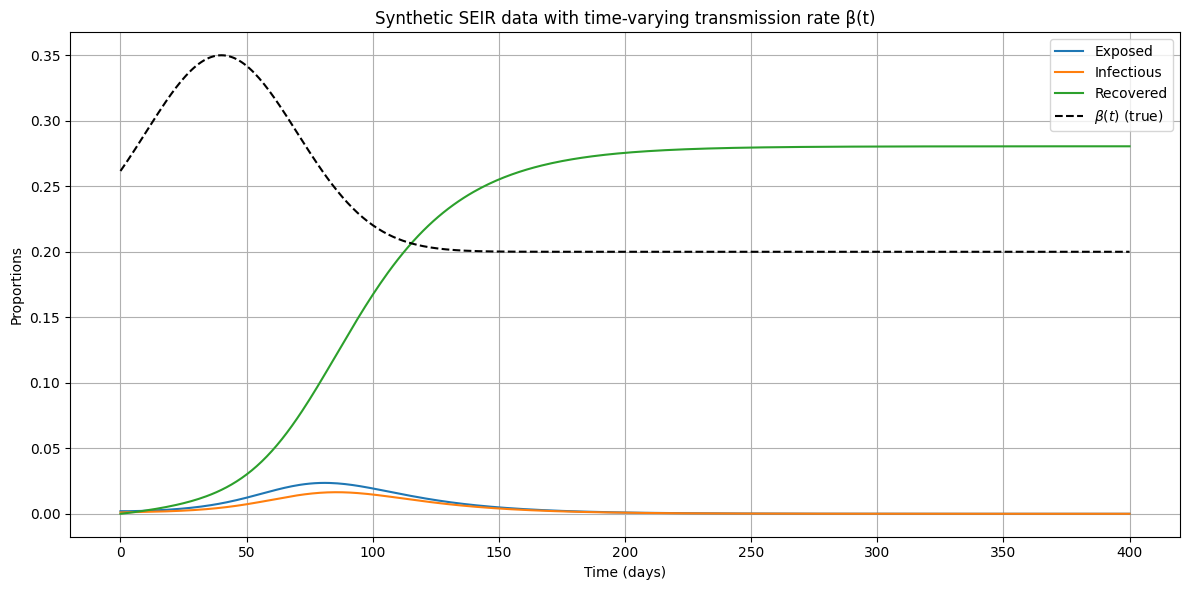

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Parameters
sigma = 1 / 6.57 #per day
gamma = 1 / 5 #per day
delta = 0.015 # per day(prof ppr)

# Time-varying beta function (simulate second wave)
def beta_func(t):
    return (0.4 + 0.3 * np.exp(-((t - 40) ** 2) / (2 * 30 ** 2)))/2

# SEIR model
def seir_model(y, t):
    S, E, I, R = y
    N = S + E + I + R
    beta = beta_func(t)
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - sigma * E
    dIdt = sigma * E - (gamma + delta) * I
    dRdt = gamma * I
    return [dSdt, dEdt, dIdt, dRdt]

# Initial conditions
N0 = 1.0
I0 = 0.001
E0 = 0.002
R0 = 0.0
S0 = N0 - I0 - E0 - R0
y0 = [S0, E0, I0, R0]

# Time grid
t = np.linspace(0, 400, 401)

# Solve ODE
sol = odeint(seir_model, y0, t)
S, E, I, R = sol.T
beta_vals = beta_func(t)

# Plot results
plt.figure(figsize=(12, 6))
# plt.plot(t, S, label="Susceptible")
plt.plot(t, E, label="Exposed")
plt.plot(t, I, label="Infectious")
plt.plot(t, R, label="Recovered")
plt.plot(t, beta_vals, '--', label=r'$\beta(t)$ (true)', color='black')
plt.xlabel("Time (days)")
plt.ylabel("Proportions")
plt.legend()
plt.grid(True)
plt.title("Synthetic SEIR data with time-varying transmission rate β(t)")
plt.tight_layout()
plt.show()


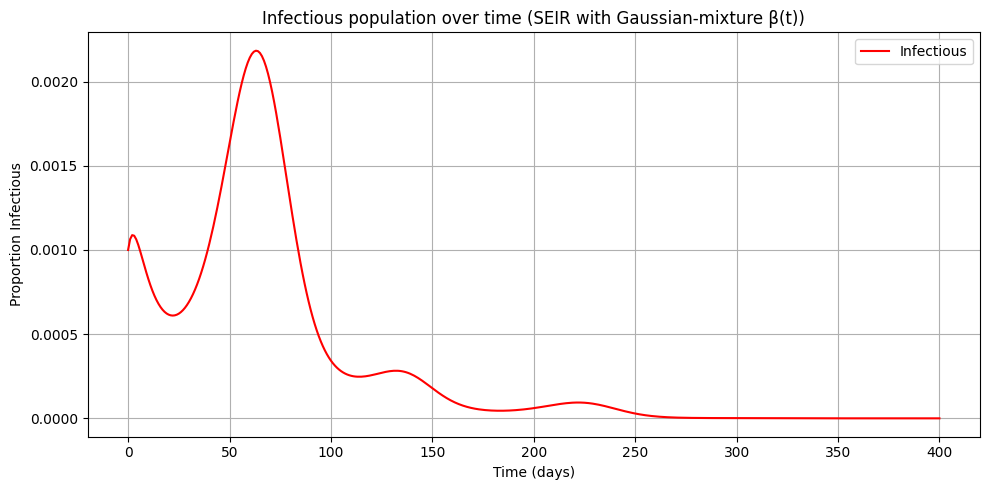

In [38]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# ---------------- Parameters ----------------
sigma = 1 / 6.57   # per day
gamma = 1 / 5      # per day
delta = 0.015      # per day

# ---------------- Gaussian Mixture β(t) ----------------
# r_m: amplitude, t_m: center, d_m: half pulse duration
r  = np.array([0.35, 0.25, 0.30, 0.22])     # amplitudes
tm = np.array([40.0, 120.0, 200.0, 300.0])  # centers
dm = np.array([30.0, 25.0, 35.0, 28.0])     # half-durations

def beta_func(t_in):
    if np.isscalar(t_in):
        return float(np.sum(r * np.exp(-((t_in - tm) ** 2) / (dm ** 2))))
    t = np.asarray(t_in).reshape(-1, 1)
    val = np.sum(r[None, :] * np.exp(-((t - tm[None, :]) ** 2) / (dm[None, :] ** 2)), axis=1)
    return val

# ---------------- SEIR model ----------------
def seir_model(y, t):
    S, E, I, R = y
    N = S + E + I + R
    beta = beta_func(t)
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - sigma * E
    dIdt = sigma * E - (gamma + delta) * I
    dRdt = gamma * I
    return [dSdt, dEdt, dIdt, dRdt]

# ---------------- Initial conditions ----------------
N0 = 1.0
I0 = 0.001
E0 = 0.002
R0 = 0.0
S0 = N0 - I0 - E0 - R0
y0 = [S0, E0, I0, R0]

# ---------------- Time grid ----------------
t = np.linspace(0, 400, 401)

# ---------------- Solve ODE ----------------
sol = odeint(seir_model, y0, t)
S, E, I, R = sol.T

# ---------------- Plot Infectious only ----------------
plt.figure(figsize=(10, 5))
plt.plot(t, I, label="Infectious", color="red")
plt.xlabel("Time (days)")
plt.ylabel("Proportion Infectious")
plt.title("Infectious population over time (SEIR with Gaussian-mixture β(t))")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import time

# -------------------------------------
# 1. Generate SEIR synthetic data
# -------------------------------------
sigma = 1 / 6.57
gamma = 1 / 5
delta = 0.01
N = 1.0

def true_beta(t):
    return 0.4 + 0.3 * jnp.exp(-((t - 200) ** 2) / (2 * 30 ** 2))

def seir_model(y, t):
    S, E, I, R = y
    beta = true_beta(t)
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - sigma * E
    dIdt = sigma * E - (gamma + delta) * I
    dRdt = gamma * I
    return [dSdt, dEdt, dIdt, dRdt]

I0, E0, R0 = 0.001, 0.002, 0.0
S0 = N - I0 - E0 - R0
y0 = [S0, E0, I0, R0]

t_dense = jnp.linspace(0, 400, 401)[:, None]
sol = odeint(seir_model, y0, t_dense.ravel())
S_data, E_data, I_data, R_data = map(jnp.array, zip(*sol))

sample_rate = 10
t_data = t_dense[::sample_rate]
I_sampled = I_data[::sample_rate, None]
IC = jnp.array([[S0, E0, I0, R0]])

# -------------------------------------
# 2. Define network
# -------------------------------------
def init_params(layers):
    keys = jax.random.split(jax.random.PRNGKey(0), len(layers) - 1)
    params = []
    for k, n_in, n_out in zip(keys, layers[:-1], layers[1:]):
        W = jax.random.normal(k, (n_in, n_out)) / jnp.sqrt(n_in)
        B = jnp.zeros(n_out)
        params.append({'W': W, 'B': B})
    return params

def fwd(params, t):
    X = t/400
    X = t.reshape(-1, 1)
    *hidden, last = params
    for layer in hidden:
        X = jnp.tanh(X @ layer['W'] + layer['B'])
    return X @ last['W'] + last['B']

def fwd_single(params, t_scalar):
    t_vec = jnp.array([[t_scalar]])
    return fwd(params, t_vec)[0]

def split_outputs(vec):
    S, E, I, R, beta = jnp.split(vec, 5)
    return S[0], E[0], I[0], R[0], jax.nn.softplus(beta[0])

# -------------------------------------
# 3. Define loss
# -------------------------------------
def MSE(true, pred): return jnp.mean((true - pred) ** 2)

def ODE_residuals(params, t):
    def S_fn(t): return split_outputs(fwd_single(params, t))[0]
    def E_fn(t): return split_outputs(fwd_single(params, t))[1]
    def I_fn(t): return split_outputs(fwd_single(params, t))[2]
    def R_fn(t): return split_outputs(fwd_single(params, t))[3]
    def beta_fn(t): return split_outputs(fwd_single(params, t))[4]

    dS = jax.grad(S_fn)(t)
    dE = jax.grad(E_fn)(t)
    dI = jax.grad(I_fn)(t)
    dR = jax.grad(R_fn)(t)

    S, E, I, R, beta = split_outputs(fwd_single(params, t))

    res1 = dS + beta * S * I / N
    res2 = dE - beta * S * I / N + sigma * E
    res3 = dI - sigma * E + (gamma + delta) * I
    res4 = dR - gamma * I

    return res1**2, res2**2, res3**2, res4**2

def loss_fn(params, t_ic, ic, t_d, I_d, t_phys, loss_weight):
    preds_d = fwd(params, t_d)
    I_pred = preds_d[:, 2]
    loss_data = MSE(I_pred, I_d[:, 0])

    pred_ic = fwd(params, t_ic)
    loss_ic = sum([MSE(pred_ic[0, i], ic[0, i]) for i in range(4)])

    res = jax.vmap(lambda t: ODE_residuals(params, t))(t_phys[:, 0])
    loss_phys = jnp.mean(jnp.stack(res))

    return loss_weight[0] * loss_ic + loss_weight[1] * loss_data + loss_weight[2] * loss_phys

@jax.jit
def update(opt_state, params, t_ic, ic, t_d, I_d, t_phys, loss_weight):
    grads = jax.grad(loss_fn)(params, t_ic, ic, t_d, I_d, t_phys, loss_weight)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return opt_state, params

# -------------------------------------
# 4. Training
# -------------------------------------
layers = [1, 64, 64, 64, 5]
params = init_params(layers)

t_ic = jnp.array([[0.0]])
t_phys = jnp.linspace(0, 400, 200)[:, None]

epochs_phase1 = 0
epochs_phase2 = 30000

scheduler = optax.cosine_decay_schedule(0.001, epochs_phase2, alpha=0.0)
optimizer = optax.adamw(scheduler)
opt_state = optimizer.init(params)

loss_weight_phase1 = [1, 1, 0]
loss_weight_phase2 = [1, 1, 1]

history = []
start = time.time()
for ep in range(epochs_phase1 + epochs_phase2 + 1):
    lw = loss_weight_phase1 if ep <= epochs_phase1 else loss_weight_phase2
    opt_state, params = update(opt_state, params, t_ic, IC, t_data, I_sampled, t_phys, lw)

    if ep % 500 == 0:
        lval = loss_fn(params, t_ic, IC, t_data, I_sampled, t_phys, lw)
        history.append((ep, lval))
        print(f"Epoch {ep}: loss = {lval:.3e}")
print(f"Training completed in {time.time() - start:.1f} seconds.")

# -------------------------------------
# 5. Plotting
# -------------------------------------
preds = fwd(params, t_dense)
beta_pred = jax.nn.softplus(preds[:, 4])
beta_true = true_beta(t_dense)

plt.figure(figsize=(10, 5))
plt.plot(t_dense, beta_true, '--k', label='True β(t)')
plt.plot(t_dense, beta_pred, '-r', label='Predicted β(t)')
plt.xlabel('Time')
plt.ylabel('Transmission Rate β(t)')
plt.title('PINN-estimated β(t)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Epoch 0: loss = 9.620e-01
Epoch 500: loss = 2.663e-04
Epoch 1000: loss = 2.638e-04
Epoch 1500: loss = 2.628e-04
Epoch 2000: loss = 2.623e-04
Epoch 2500: loss = 2.621e-04
Epoch 3000: loss = 2.620e-04
Epoch 3500: loss = 2.620e-04
Epoch 4000: loss = 2.620e-04
Epoch 4500: loss = 2.620e-04
Epoch 5000: loss = 2.627e-04
Epoch 5500: loss = 2.927e-04
Epoch 6000: loss = 2.620e-04
Epoch 6500: loss = 2.631e-04
Epoch 7000: loss = 2.650e-04
Epoch 7500: loss = 2.620e-04


KeyboardInterrupt: 

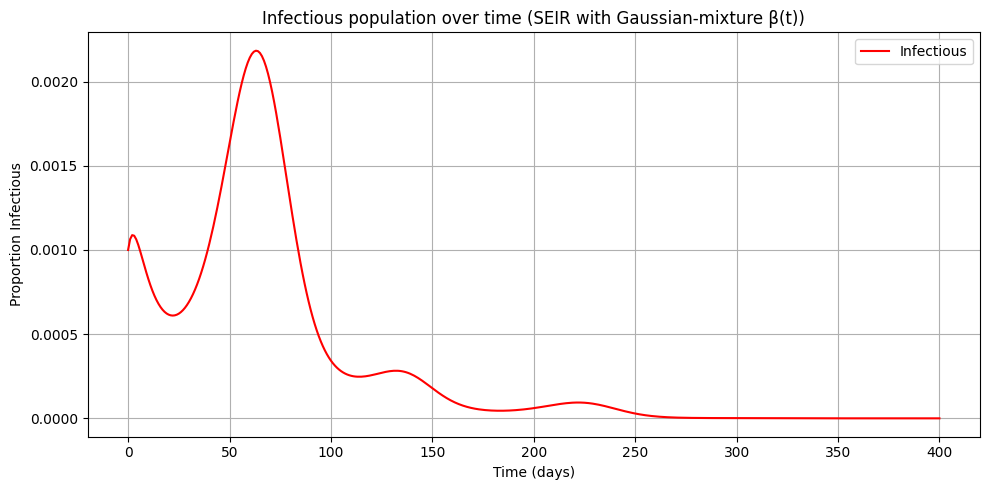

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# ---------------- Parameters ----------------
sigma = 1 / 6.57   # per day
gamma = 1 / 5      # per day
delta = 0.015      # per day

# ---------------- Gaussian Mixture β(t) ----------------
# r_m: amplitude, t_m: center, d_m: half pulse duration
r  = np.array([0.35, 0.25, 0.30, 0.22])     # amplitudes
tm = np.array([40.0, 120.0, 200.0, 300.0])  # centers
dm = np.array([30.0, 25.0, 35.0, 28.0])     # half-durations

def beta_func(t_in):
    if np.isscalar(t_in):
        return float(np.sum(r * np.exp(-((t_in - tm) ** 2) / (dm ** 2))))
    t = np.asarray(t_in).reshape(-1, 1)
    val = np.sum(r[None, :] * np.exp(-((t - tm[None, :]) ** 2) / (dm[None, :] ** 2)), axis=1)
    return val

# ---------------- SEIR model ----------------
def seir_model(y, t):
    S, E, I, R = y
    N = S + E + I + R
    beta = beta_func(t)
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - sigma * E
    dIdt = sigma * E - (gamma + delta) * I
    dRdt = gamma * I
    return [dSdt, dEdt, dIdt, dRdt]

# ---------------- Initial conditions ----------------
N0 = 1.0
I0 = 0.001
E0 = 0.002
R0 = 0.0
S0 = N0 - I0 - E0 - R0
y0 = [S0, E0, I0, R0]

# ---------------- Time grid ----------------
t = np.linspace(0, 400, 401)

# ---------------- Solve ODE ----------------
sol = odeint(seir_model, y0, t)
S, E, I, R = sol.T

# ---------------- Plot Infectious only ----------------
plt.figure(figsize=(10, 5))
plt.plot(t, I, label="Infectious", color="red")
plt.xlabel("Time (days)")
plt.ylabel("Proportion Infectious")
plt.title("Infectious population over time (SEIR with Gaussian-mixture β(t))")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [27]:
# ============================================
# SEIR (4-state) PINN with KAN/Chebyshev basis
# ============================================

# --- Imports ---
import os, time, sys
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
from jax import jacrev
from jax.tree_util import tree_flatten
import optax
import matplotlib.pyplot as plt

# --------------------------------------------
# (A) Synthetic data generator (4 columns: S,E,I,R)
# --------------------------------------------
def generate_seir_data(filename="simulated_data_seir.npz",
                       T=300, t_end=180.0,
                       r=(0.35, 0.25, 0.30, 0.22),
                       tm=(40.0, 120.0, 200.0, 300.0),
                       dm=(30.0, 25.0, 35.0, 28.0)):
    from scipy.integrate import odeint

    t = np.linspace(0.0, t_end, T)                 # (T,)
    t_i = np.array([[t[0]]], dtype=float)          # (1,1) initial-condition time

    # SEIR parameters
    sigma = 1 / 6.57
    gamma = 1 / 5
    delta = 0.015

    r  = np.array(r,  dtype=float)
    tm = np.array(tm, dtype=float)
    dm = np.array(dm, dtype=float)

    def beta_func(tt):
        if np.isscalar(tt):
            return float(np.sum(r * np.exp(-((tt - tm)**2) / (dm**2))))
        tcol = np.asarray(tt).reshape(-1,1)
        return np.sum(r[None,:] * np.exp(-((tcol - tm[None,:])**2) / (dm[None,:]**2)), axis=1)

    def rhs(y, tt):
        S, E, I, R = y
        N = S + E + I + R
        beta = beta_func(tt)
        dS = -beta * S * I / N
        dE =  beta * S * I / N - sigma * E
        dI =  sigma * E - (gamma + delta) * I
        dR =  gamma * I
        return [dS, dE, dI, dR]

    # IC
    N0, I0, E0, R0 = 1.0, 0.001, 0.002, 0.0
    S0 = N0 - I0 - E0 - R0
    y0 = [S0, E0, I0, R0]

    sol = odeint(rhs, y0, t)  # (T,4)
    data = sol.astype(float)

    # (optional) multiplicative noise (per-var)
    noise_level = 0.0
    if noise_level > 0:
        noise = np.random.uniform(-1, 1, size=data.shape)
        data = data * (1 + noise_level * noise)

    # scale factors per state
    max_scl = np.maximum(1.0, np.max(np.abs(data), axis=0))  # (4,)
    IC = np.array([[S0, E0, I0, R0]], dtype=float)           # (1,4)

    np.savez(filename, data=data, t=t, t_i=t_i, IC=IC, max_scl=max_scl)
    print(f"Saved {filename}: data.shape={data.shape}, max_scl={max_scl}")

# Generate once (comment this out if you already have data)
generate_seir_data()

# --------------------------------------------
# (B) Load data (4 states)
# --------------------------------------------
loaded = np.load("simulated_data_seir.npz")
data   = loaded["data"]        # (T,4) -> S,E,I,R
t_data = loaded["t"]           # (T,)
t_i    = loaded["t_i"]         # (1,1)
IC     = loaded["IC"]          # (1,4)
max_scl= loaded["max_scl"]     # (4,)

# Training times
t_dense = jnp.linspace(0.0, float(t_data[-1]), len(t_data))[:, None]  # (T,1)

# Which variables have data? (choose any subset of 0:S,1:E,2:I,3:R)
x_index = [2]  # e.g., Infectious only. Use [0,1,2,3] if you have all.






# _____________PINNs__________________________
# --- Model Initialization ---
def init_params(layers, key):
    keys = jax.random.split(key, len(layers) - 1)
    params = []
    for k, n_in, n_out in zip(keys, layers[:-1], layers[1:]):
        W = jax.random.normal(k, (n_in, n_out)) / jnp.sqrt(n_in)
        B = jnp.zeros(n_out)
        params.append({'W': W, 'B': B})
    # Add trainable Ks at the end
    Ks = {f"K{i+1}": jnp.array(1.0) for i in k_index}
    params[-1]['Ks'] = Ks
    return params

# --- Forward Model ---
def fwd_mlp(params, t):
    X = 0.01 * t
    inputs = X
    *hidden, last = params
    for layer in hidden:
        inputs = jax.nn.swish(inputs @ layer['W'] + layer['B'])
    return inputs @ last['W'] + last['B']

# --------------------------------------------
# (C) KAN model (Chebyshev-based)
# --------------------------------------------
def init_params_kan(layers, degree, key=jax.random.PRNGKey(1283)):
    # layers like [1, 70, 70, 4]
    keys = jax.random.split(key, len(layers) - 1)
    params = []
    # Hidden layers with Chebyshev coeffs
    for k, n_in, n_out in zip(keys[:-1], layers[:-2], layers[1:-1]):
        W = jax.random.normal(k, shape=(n_in, n_out, degree + 1)) / jnp.sqrt(n_in * (degree + 1))
        B = jax.random.normal(k, shape=(n_out,))
        params.append({'W': W, 'B': B})
    # Linear readout
    W = jax.random.normal(keys[-1], shape=(layers[-2], layers[-1])) / jnp.sqrt(layers[-2])
    B = jax.random.normal(keys[-1], shape=(layers[-1],))
    params.append({'W': W, 'B': B})
    return params

def chebyshev_recursive(x, degree):
    if degree == 0:
        return x * 0 + 1
    if degree == 1:
        return x
    Tm2 = x * 0 + 1
    Tm1 = x
    for n in range(2, degree + 1):
        Tn = 2 * x * Tm1 - Tm2
        Tm2, Tm1 = Tm1, Tn
    return Tm1

def fwd(params, t, activation=jax.nn.tanh, degree=3):
    t = t / float(t_data[-1])                # normalize time to ~[0,1]
    X = t.reshape((-1, 1))                   # (B,1)
    *hidden, last = params
    for layer in hidden:
        X = activation(X)
        coeffs = layer['W']                  # (in,out,deg+1)
        deg = coeffs.shape[2] - 1
        X_stack = jnp.stack([chebyshev_recursive(X, d) for d in range(deg + 1)], axis=-1)  # (B,in,deg+1)
        X = jnp.einsum("bid,iod->bo", X_stack, coeffs)   # (B,out)
        X = activation(X)
    return jnp.dot(X, last['W']) + last['B']             # (B,4)

# --------------------------------------------
# (D) Losses (IC, Data, ODE)
# --------------------------------------------
@jax.jit
def MSE(true, pred):  # true/pred: (B,dim) or (1,dim)
    return jnp.mean((true - pred) ** 2)

def ODE_loss(params, t, y_func, max_scl):
    """
    Returns list of 4 residual arrays (one per state): each (T,1,1)
    """
    # SEIR constants
    sigma = 1 / 6.57
    gamma = 1 / 5
    delta = 0.015

    # Gaussian-mixture beta(t) (match data gen)
    r  = jnp.array([0.35, 0.25, 0.30, 0.22])
    tm = jnp.array([40.0, 120.0, 200.0, 300.0])
    dm = jnp.array([30.0, 25.0, 35.0, 28.0])

    def beta_fn(tt):
        return jnp.sum(r * jnp.exp(-((tt - tm)**2) / (dm**2)))

    y_vals = jax.vmap(y_func)(t)           # (T,4)
    dy_dt  = jax.vmap(jacrev(y_func))(t)   # (T,4,1)

    # Scale up to physical scale before RHS, then divide back (as in your code)
    S = y_vals[:, 0:1] * max_scl[0]
    E = y_vals[:, 1:2] * max_scl[1]
    I = y_vals[:, 2:3] * max_scl[2]
    R = y_vals[:, 3:4] * max_scl[3]

    beta_t = jax.vmap(beta_fn)(t.squeeze()).reshape(-1,1)
    N = S + E + I + R

    dS = -beta_t * S * I / N
    dE =  beta_t * S * I / N - sigma * E
    dI =  sigma * E - (gamma + delta) * I
    dR =  gamma * I

    # Scale back
    rhs_S = dS / max_scl[0]
    rhs_E = dE / max_scl[1]
    rhs_I = dI / max_scl[2]
    rhs_R = dR / max_scl[3]

    res_S = dy_dt[:, 0:1, :] - rhs_S.reshape(-1,1,1)
    res_E = dy_dt[:, 1:2, :] - rhs_E.reshape(-1,1,1)
    res_I = dy_dt[:, 2:3, :] - rhs_I.reshape(-1,1,1)
    res_R = dy_dt[:, 3:4, :] - rhs_R.reshape(-1,1,1)

    return [res_S, res_E, res_I, res_R]

def loss_fun(params, lambdas, t_i, t_d, t_c, data_IC, data, max_scl):
    y_func = lambda tt: fwd(params, tt.reshape(1,1)).squeeze()  # -> (4,)
    residuals = ODE_loss(params, t_c, y_func, max_scl)
    loss_odes = [lambdas[i] * jnp.mean(res**2) for i, res in enumerate(residuals)]

    # IC loss
    pred_IC = fwd(params, t_i)  # (1,4)
    loss_IC = MSE(jnp.asarray(data_IC), pred_IC)

    # Data loss (only over chosen indices)
    pred_d = fwd(params, t_d)   # (T,4)
    loss_data = sum(MSE(jnp.asarray(data)[:, i:i+1], pred_d[:, i:i+1]) for i in x_index)

    return loss_IC, loss_data, *loss_odes  # total of 2 + 4 = 6 terms

def loss_fun_total(params, lambdas, t_i, t_d, t_c, data_IC, data, loss_weight, max_scl):
    losses = loss_fun(params, lambdas, t_i, t_d, t_c, data_IC, data, max_scl)
    return sum(w * l for w, l in zip(loss_weight, losses))

# --------------------------------------------
# (E) Training
# --------------------------------------------
def train_model(params, lambdas, t_i, t_d, t_c, data_IC, data, max_scl, epochs, loss_weight):
    optimizer = optax.adam(1e-4)
    opt_state = optimizer.init(params)

    @jax.jit
    def update(params, opt_state):
        loss, grads = jax.value_and_grad(loss_fun_total)(
            params, lambdas, t_i, t_d, t_c, data_IC, data, loss_weight, max_scl
        )
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss

    for epoch in range(epochs):
        params, opt_state, loss = update(params, opt_state)
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, Loss: {float(loss):.2e}")
    return params

# --------------------------------------------
# (F) Plotting
# --------------------------------------------
def plot_predicted_vs_data(params, t_data, data, scale_factor, run_id):
    pred = fwd(params, jnp.asarray(t_data).reshape(-1,1))
    var_names = ['S', 'E', 'I', 'R']
    fig, axs = plt.subplots(2, 2, figsize=(10,6))
    axs = axs.flatten()
    for i in range(4):
        axs[i].plot(t_data, data[:, i] * scale_factor[i], 'b-', label='True')
        axs[i].plot(t_data, pred[:, i] * scale_factor[i], 'k--', label='PINN')
        axs[i].set_title(var_names[i]); axs[i].grid(True)
        if i == 0: axs[i].legend()
    plt.tight_layout()
    os.makedirs("multi_run_results", exist_ok=True)
    plt.savefig(f"pred_vs_true_run{run_id}.pdf")
    plt.close()

# --------------------------------------------
# (G) Run multiple trainings
# --------------------------------------------
#kan layer
layers = [1, 15, 15,15, 4]                 # output 4 states
loss_weight = [0.5, 1.0] + [1]*4      # IC, Data, then 4 ODE residuals
results = []

for run_id in range(1):
    print(f"\n=== Run {run_id} ===")
    key = jax.random.PRNGKey(run_id*706)
    params = init_params_kan(layers, degree=3, key=key)
    lambdas = [1.0] * 4

    trained = train_model(params, lambdas,
                          jnp.asarray(t_i), jnp.asarray(t_dense), jnp.asarray(t_dense),
                          jnp.asarray(IC), jnp.asarray(data), jnp.asarray(max_scl),
                          epochs=150001, loss_weight=loss_weight)

    # Save params (flatten like before)
    flat, _ = tree_flatten(trained)
    np.savez(f"multi_run_results/params_run{run_id}.npz", *[np.array(p) for p in flat])

    plot_predicted_vs_data(trained, t_data, data, max_scl, run_id)

print("✅ Done. Results saved in multi_run_results/")


Saved simulated_data_seir.npz: data.shape=(300, 4), max_scl=[1. 1. 1. 1.]

=== Run 0 ===
Epoch 0, Loss: 1.92e+00
Epoch 1000, Loss: 6.84e-04
Epoch 2000, Loss: 1.38e-04
Epoch 3000, Loss: 8.15e-05
Epoch 4000, Loss: 4.60e-05
Epoch 5000, Loss: 2.67e-05
Epoch 6000, Loss: 1.86e-05
Epoch 7000, Loss: 1.33e-05
Epoch 8000, Loss: 8.83e-06
Epoch 9000, Loss: 5.35e-06
Epoch 10000, Loss: 2.90e-06
Epoch 11000, Loss: 1.36e-06
Epoch 12000, Loss: 6.52e-07
Epoch 13000, Loss: 4.00e-07
Epoch 14000, Loss: 2.83e-07
Epoch 15000, Loss: 2.23e-07
Epoch 16000, Loss: 1.83e-07
Epoch 17000, Loss: 1.55e-07
Epoch 18000, Loss: 1.41e-07
Epoch 19000, Loss: 1.13e-07
Epoch 20000, Loss: 9.85e-08
Epoch 21000, Loss: 8.59e-08
Epoch 22000, Loss: 7.58e-08
Epoch 23000, Loss: 6.88e-08
Epoch 24000, Loss: 6.34e-08
Epoch 25000, Loss: 5.54e-08
Epoch 26000, Loss: 5.08e-08
Epoch 27000, Loss: 6.88e-06
Epoch 28000, Loss: 4.34e-08
Epoch 29000, Loss: 4.04e-08
Epoch 30000, Loss: 3.76e-08
Epoch 31000, Loss: 3.52e-08
Epoch 32000, Loss: 3.31e-08


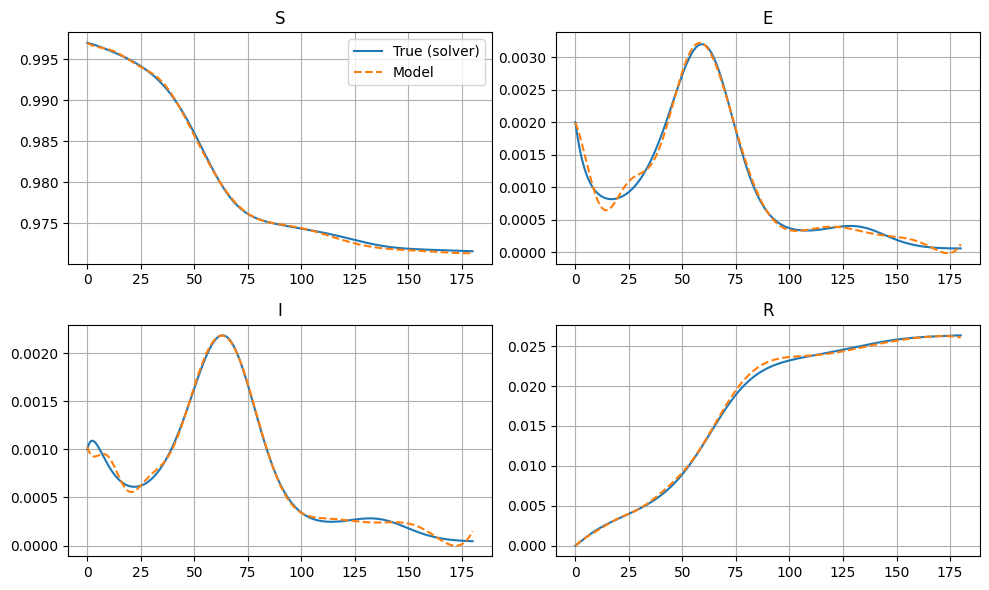

Plotted final comparison and saved to multi_run_results/pred_vs_true_runfinal.pdf


In [28]:
def plot_predicted_vs_data(params, t_data, data_true, scale_factor, run_id, show=True):
    """
    Plots S,E,I,R: true (solver) vs model prediction.
    Saves a PDF and optionally shows the figure inline.
    """
    pred = fwd(params, jnp.asarray(t_data).reshape(-1,1))
    var_names = ['S', 'E', 'I', 'R']
    fig, axs = plt.subplots(2, 2, figsize=(10,6))
    axs = axs.flatten()
    for i in range(4):
        axs[i].plot(t_data, data_true[:, i] * scale_factor[i], label='True (solver)')
        axs[i].plot(t_data, pred[:, i] * scale_factor[i], linestyle='--', label='Model')
        axs[i].set_title(var_names[i]); axs[i].grid(True)
        if i == 0: axs[i].legend()
    plt.tight_layout()
    os.makedirs("multi_run_results", exist_ok=True)
    plt.savefig(f"multi_run_results/pred_vs_true_run{run_id}.pdf")
    if show:
        plt.show()
    else:
        plt.close()
# --- Final visualization for the last trained model ---
# 'trained' contains the params from the last run in the loop above.
plot_predicted_vs_data(trained, t_data, data, max_scl, run_id="final", show=True)
print("Plotted final comparison and saved to multi_run_results/pred_vs_true_runfinal.pdf")


In [36]:
# ============================================
# SEIR (4-state) PINN with KAN/Chebyshev basis
# ============================================

# --- Imports ---
import os, time, sys
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
from jax import jacrev
from jax.tree_util import tree_flatten
import optax
import matplotlib.pyplot as plt

# --------------------------------------------
# (A) Synthetic data generator (4 columns: S,E,I,R)
# --------------------------------------------
def generate_seir_data(filename="simulated_data_seir.npz",
                       T=300, t_end=180.0,
                       r=(0.35, 0.25, 0.30, 0.22),
                       tm=(40.0, 120.0, 200.0, 300.0),
                       dm=(30.0, 25.0, 35.0, 28.0)):
    from scipy.integrate import odeint

    t = np.linspace(0.0, t_end, T)                 # (T,)
    t_i = np.array([[t[0]]], dtype=float)          # (1,1) initial-condition time

    # SEIR parameters
    sigma = 1 / 6.57
    gamma = 1 / 5
    delta = 0.015

    r  = np.array(r,  dtype=float)
    tm = np.array(tm, dtype=float)
    dm = np.array(dm, dtype=float)

    def beta_func(tt):
        if np.isscalar(tt):
            return float(np.sum(r * np.exp(-((tt - tm)**2) / (dm**2))))
        tcol = np.asarray(tt).reshape(-1,1)
        return np.sum(r[None,:] * np.exp(-((tcol - tm[None,:])**2) / (dm[None,:]**2)), axis=1)

    def rhs(y, tt):
        S, E, I, R = y
        N = S + E + I + R
        beta = beta_func(tt)
        dS = -beta * S * I / N
        dE =  beta * S * I / N - sigma * E
        dI =  sigma * E - (gamma + delta) * I
        dR =  gamma * I
        return [dS, dE, dI, dR]

    # IC
    N0, I0, E0, R0 = 1.0, 0.001, 0.002, 0.0
    S0 = N0 - I0 - E0 - R0
    y0 = [S0, E0, I0, R0]

    sol = odeint(rhs, y0, t)  # (T,4)
    data = sol.astype(float)

    # (optional) multiplicative noise (per-var)
    noise_level = 0.0
    if noise_level > 0:
        noise = np.random.uniform(-1, 1, size=data.shape)
        data = data * (1 + noise_level * noise)

    # scale factors per state
    max_scl = np.maximum(1.0, np.max(np.abs(data), axis=0))  # (4,)
    IC = np.array([[S0, E0, I0, R0]], dtype=float)           # (1,4)

    np.savez(filename, data=data, t=t, t_i=t_i, IC=IC, max_scl=max_scl)
    print(f"Saved {filename}: data.shape={data.shape}, max_scl={max_scl}")

# Generate once (comment this out if you already have data)
generate_seir_data()

# --------------------------------------------
# (B) Load data (4 states)
# --------------------------------------------
loaded = np.load("simulated_data_seir.npz")
data   = loaded["data"]        # (T,4) -> S,E,I,R
t_data = loaded["t"]           # (T,)
t_i    = loaded["t_i"]         # (1,1)
IC     = loaded["IC"]          # (1,4)
max_scl= loaded["max_scl"]     # (4,)

# Training times
t_dense = jnp.linspace(0.0, float(t_data[-1]), len(t_data))[:, None]  # (T,1)

# Which variables have data? (choose any subset of 0:S,1:E,2:I,3:R)
x_index = [2]  # e.g., Infectious only. Use [0,1,2,3] if you have all.






# _____________PINNs__________________________
# --- Model Initialization ---
def init_params(layers, key):
    keys = jax.random.split(key, len(layers) - 1)
    params = []
    for k, n_in, n_out in zip(keys, layers[:-1], layers[1:]):
        W = jax.random.normal(k, (n_in, n_out)) / jnp.sqrt(n_in)
        B = jnp.zeros(n_out)
        params.append({'W': W, 'B': B})
    # Add trainable Ks at the end
    # Ks = {f"K{i+1}": jnp.array(1.0) for i in k_index}
    # params[-1]['Ks'] = Ks
    return params

# --- Forward Model ---
# def fwd(params, t):
#     X = t/float(t_data[-1])
#     inputs = X
#     *hidden, last = params
#     for layer in hidden:
#         inputs = jax.nn.tanh(inputs @ layer['W'] + layer['B'])

#     return inputs @ last['W'] + last['B']
def fwd(params, t):
    X = t / float(t_data[-1])
    H = X
    *hidden, last = params
    for layer in hidden:
        H = jax.nn.tanh(H @ layer['W'] + layer['B'])
    raw = H @ last['W'] + last['B']        # (B,4), unconstrained
    out = jax.nn.softmax(raw, axis=1)      # (B,4), ≥0 and sums to 1
    return out


# --------------------------------------------
# (D) Losses (IC, Data, ODE)
# --------------------------------------------
@jax.jit
def MSE(true, pred):  # true/pred: (B,dim) or (1,dim)
    return jnp.mean((true - pred) ** 2)

def ODE_loss(params, t, y_func, max_scl):
    """
    Returns list of 4 residual arrays (one per state): each (T,1,1)
    """
    # SEIR constants
    sigma = 1 / 6.57
    gamma = 1 / 5
    delta = 0.015

    # Gaussian-mixture beta(t) (match data gen)
    r  = jnp.array([0.35, 0.25, 0.30, 0.22])
    tm = jnp.array([40.0, 120.0, 200.0, 300.0])
    dm = jnp.array([30.0, 25.0, 35.0, 28.0])

    def beta_fn(tt):
        return jnp.sum(r * jnp.exp(-((tt - tm)**2) / (dm**2)))

    y_vals = jax.vmap(y_func)(t)           # (T,4)
    dy_dt  = jax.vmap(jacrev(y_func))(t)   # (T,4,1)

    # Scale up to physical scale before RHS, then divide back (as in your code)
    S = y_vals[:, 0:1] * max_scl[0]
    E = y_vals[:, 1:2] * max_scl[1]
    I = y_vals[:, 2:3] * max_scl[2]
    R = y_vals[:, 3:4] * max_scl[3]

    beta_t = jax.vmap(beta_fn)(t.squeeze()).reshape(-1,1)
    N = S + E + I + R

    dS = -beta_t * S * I / N
    dE =  beta_t * S * I / N - sigma * E
    dI =  sigma * E - (gamma + delta) * I
    dR =  gamma * I

    # Scale back
    rhs_S = dS / max_scl[0]
    rhs_E = dE / max_scl[1]
    rhs_I = dI / max_scl[2]
    rhs_R = dR / max_scl[3]

    res_S = dy_dt[:, 0:1, :] - rhs_S.reshape(-1,1,1)
    res_E = dy_dt[:, 1:2, :] - rhs_E.reshape(-1,1,1)
    res_I = dy_dt[:, 2:3, :] - rhs_I.reshape(-1,1,1)
    res_R = dy_dt[:, 3:4, :] - rhs_R.reshape(-1,1,1)

    return [res_S, res_E, res_I, res_R]

def loss_fun(params, lambdas, t_i, t_d, t_c, data_IC, data, max_scl):
    y_func = lambda tt: fwd(params, tt.reshape(1,1)).squeeze()  # -> (4,)
    residuals = ODE_loss(params, t_c, y_func, max_scl)
    loss_odes = [lambdas[i] * jnp.mean(res**2) for i, res in enumerate(residuals)]

    # IC loss
    pred_IC = fwd(params, t_i)  # (1,4)
    loss_IC = MSE(jnp.asarray(data_IC), pred_IC)

    # Data loss (only over chosen indices)
    pred_d = fwd(params, t_d)   # (T,4)
    loss_data = sum(MSE(jnp.asarray(data)[:, i:i+1], pred_d[:, i:i+1]) for i in x_index)

    return loss_IC, loss_data, *loss_odes  # total of 2 + 4 = 6 terms

def loss_fun_total(params, lambdas, t_i, t_d, t_c, data_IC, data, loss_weight, max_scl):
    losses = loss_fun(params, lambdas, t_i, t_d, t_c, data_IC, data, max_scl)
    return sum(w * l for w, l in zip(loss_weight, losses))

# --------------------------------------------
# (E) Training
# --------------------------------------------
def train_model(params, lambdas, t_i, t_d, t_c, data_IC, data, max_scl, epochs, loss_weight):
    optimizer = optax.adam(1e-4)
    opt_state = optimizer.init(params)

    @jax.jit
    def update(params, opt_state):
        loss, grads = jax.value_and_grad(loss_fun_total)(
            params, lambdas, t_i, t_d, t_c, data_IC, data, loss_weight, max_scl
        )
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss

    for epoch in range(epochs):
        params, opt_state, loss = update(params, opt_state)
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, Loss: {float(loss):.2e}")
    return params

# --------------------------------------------
# (F) Plotting
# --------------------------------------------
def plot_predicted_vs_data(params, t_data, data, scale_factor, run_id):
    pred = fwd(params, jnp.asarray(t_data).reshape(-1,1))
    var_names = ['S', 'E', 'I', 'R']
    fig, axs = plt.subplots(2, 2, figsize=(10,6))
    axs = axs.flatten()
    for i in range(4):
        axs[i].plot(t_data, data[:, i] * scale_factor[i], 'b-', label='True')
        axs[i].plot(t_data, pred[:, i] * scale_factor[i], 'k--', label='PINN')
        axs[i].set_title(var_names[i]); axs[i].grid(True)
        if i == 0: axs[i].legend()
    plt.tight_layout()
    os.makedirs("multi_run_results", exist_ok=True)
    plt.savefig(f"pred_vs_true_run{run_id}.pdf")
    plt.close()

# --------------------------------------------
# (G) Run multiple trainings
# --------------------------------------------
#kan layer
layers = [1, 128, 128,128, 4]                 # output 4 states
loss_weight = [0.5, 1.0] + [1]*4      # IC, Data, then 4 ODE residuals
results = []

for run_id in range(1):
    print(f"\n=== Run {run_id} ===")
    key = jax.random.PRNGKey(run_id*706)
    params = init_params(layers, key=key)
    lambdas = [1.0] * 4

    trained = train_model(params, lambdas,
                          jnp.asarray(t_i), jnp.asarray(t_dense), jnp.asarray(t_dense),
                          jnp.asarray(IC), jnp.asarray(data), jnp.asarray(max_scl),
                          epochs=150001, loss_weight=loss_weight)

    # Save params (flatten like before)
    flat, _ = tree_flatten(trained)
    np.savez(f"multi_run_results/params_run{run_id}.npz", *[np.array(p) for p in flat])

    plot_predicted_vs_data(trained, t_data, data, max_scl, run_id)

print("✅ Done. Results saved in multi_run_results/")


Saved simulated_data_seir.npz: data.shape=(300, 4), max_scl=[1. 1. 1. 1.]

=== Run 0 ===
Epoch 0, Loss: 1.39e-01
Epoch 1000, Loss: 3.75e-05
Epoch 2000, Loss: 7.35e-06
Epoch 3000, Loss: 2.87e-06
Epoch 4000, Loss: 1.68e-06
Epoch 5000, Loss: 1.31e-06
Epoch 6000, Loss: 1.20e-06
Epoch 7000, Loss: 1.16e-06
Epoch 8000, Loss: 1.12e-06
Epoch 9000, Loss: 1.07e-06
Epoch 10000, Loss: 1.02e-06
Epoch 11000, Loss: 9.75e-07
Epoch 12000, Loss: 9.50e-07
Epoch 13000, Loss: 9.35e-07
Epoch 14000, Loss: 9.24e-07
Epoch 15000, Loss: 9.12e-07
Epoch 16000, Loss: 8.96e-07
Epoch 17000, Loss: 3.95e-07
Epoch 18000, Loss: 1.90e-07
Epoch 19000, Loss: 1.55e-07
Epoch 20000, Loss: 1.24e-07
Epoch 21000, Loss: 1.07e-07
Epoch 22000, Loss: 9.71e-08
Epoch 23000, Loss: 9.01e-08
Epoch 24000, Loss: 8.34e-08
Epoch 25000, Loss: 7.59e-08
Epoch 26000, Loss: 6.61e-08
Epoch 27000, Loss: 3.87e-08
Epoch 28000, Loss: 2.61e-08
Epoch 29000, Loss: 2.22e-08
Epoch 30000, Loss: 2.01e-08
Epoch 31000, Loss: 1.89e-08
Epoch 32000, Loss: 1.81e-08


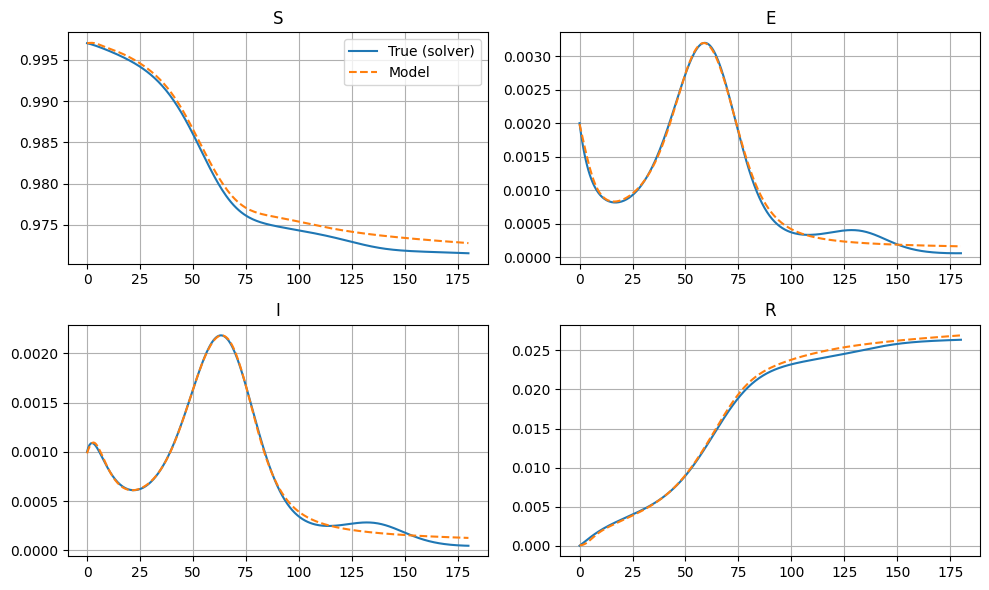

Plotted final comparison and saved to multi_run_results/pred_vs_true_runfinal.pdf


In [37]:
def plot_predicted_vs_data(params, t_data, data_true, scale_factor, run_id, show=True):
    """
    Plots S,E,I,R: true (solver) vs model prediction.
    Saves a PDF and optionally shows the figure inline.
    """
    pred = fwd(params, jnp.asarray(t_data).reshape(-1,1))
    var_names = ['S', 'E', 'I', 'R']
    fig, axs = plt.subplots(2, 2, figsize=(10,6))
    axs = axs.flatten()
    for i in range(4):
        axs[i].plot(t_data, data_true[:, i] * scale_factor[i], label='True (solver)')
        axs[i].plot(t_data, pred[:, i] * scale_factor[i], linestyle='--', label='Model')
        axs[i].set_title(var_names[i]); axs[i].grid(True)
        if i == 0: axs[i].legend()
    plt.tight_layout()
    os.makedirs("multi_run_results", exist_ok=True)
    plt.savefig(f"multi_run_results/pred_vs_true_run{run_id}.pdf")
    if show:
        plt.show()
    else:
        plt.close()
# --- Final visualization for the last trained model ---
# 'trained' contains the params from the last run in the loop above.
plot_predicted_vs_data(trained, t_data, data, max_scl, run_id="final", show=True)
print("Plotted final comparison and saved to multi_run_results/pred_vs_true_runfinal.pdf")


In [79]:
# ============================================
# SEIR (4-state) PINN/KAN with learned beta(t) as 5th output
# ============================================

# --- Imports ---
import os, time, sys
import numpy as np
import jax
import jax.numpy as jnp
from jax import jacrev
from jax.tree_util import tree_flatten
import optax
import matplotlib.pyplot as plt

# --------------------------------------------
# (A) Synthetic data generator (4 columns: S,E,I,R) + beta_true for inspection
# --------------------------------------------
def generate_seir_data(filename="simulated_data_seir.npz",
                       T=300, t_end=180.0,
                       r=(0.35, 0.25, 0.30, 0.22),
                       tm=(40.0, 120.0, 200.0, 300.0),
                       dm=(30.0, 25.0, 35.0, 28.0)):
    from scipy.integrate import odeint

    t = np.linspace(0.0, t_end, T)                 # (T,)
    t_i = np.array([[t[0]]], dtype=float)          # (1,1) initial-condition time

    # SEIR parameters
    sigma = 1 / 6.57
    gamma = 1 / 5
    delta = 0.015

    r  = np.array(r,  dtype=float)
    tm = np.array(tm, dtype=float)
    dm = np.array(dm, dtype=float)

    def beta_func(tt):
        if np.isscalar(tt):
            return float(np.sum(r * np.exp(-((tt - tm)**2) / (dm**2))))
        tcol = np.asarray(tt).reshape(-1,1)
        return np.sum(r[None,:] * np.exp(-((tcol - tm[None,:])**2) / (dm[None,:]**2)), axis=1)

    def rhs(y, tt):
        S, E, I, R = y
        N = S + E + I + R
        beta = beta_func(tt)
        dS = -beta * S * I / N
        dE =  beta * S * I / N - sigma * E
        dI =  sigma * E - (gamma + delta) * I
        dR =  gamma * I
        return [dS, dE, dI, dR]

    # IC
    N0, I0, E0, R0 = 1.0, 0.001, 0.002, 0.0
    S0 = N0 - I0 - E0 - R0
    y0 = [S0, E0, I0, R0]

    sol = odeint(rhs, y0, t)  # (T,4)
    data = sol.astype(float)
    beta_true = beta_func(t).astype(float)  # (T,)

    # scale factors per state
    max_scl = np.maximum(1.0, np.max(np.abs(data), axis=0))  # (4,)
    IC = np.array([[S0, E0, I0, R0]], dtype=float)           # (1,4)

    np.savez(filename, data=data, t=t, t_i=t_i, IC=IC, max_scl=max_scl, beta_true=beta_true)
    print(f"Saved {filename}: data.shape={data.shape}, max_scl={max_scl}")

# Generate once (comment this out if you already have data)
generate_seir_data()

# --------------------------------------------
# (B) Load data (4 states) + beta_true for plotting
# --------------------------------------------
loaded = np.load("simulated_data_seir.npz")
data      = loaded["data"]        # (T,4) -> S,E,I,R
t_data    = loaded["t"]           # (T,)
t_i       = loaded["t_i"]         # (1,1)
IC        = loaded["IC"]          # (1,4)
max_scl   = loaded["max_scl"]     # (4,)
beta_true = loaded.get("beta_true", None)

# Training times
t_dense = jnp.linspace(0.0, float(t_data[-1]), len(t_data))[:, None]  # (T,1)

# Which variables have data? (choose any subset of 0:S,1:E,2:I,3:R)
x_index = [0,1,2,3]  # Infectious only, e.g. use [0,1,2,3] if you have all

# --------------------------------------------
# (C) KAN model (Chebyshev-based) -> now output 5 dims: [S,E,I,R,beta_raw]
# --------------------------------------------
def init_params_kan(layers, degree, key=jax.random.PRNGKey(1283)):
    keys = jax.random.split(key, len(layers) - 1)
    params = []
    for key, n_in, n_out in zip(keys[:-1], layers[:-2], layers[1:-1]):
        W = jax.random.normal(key, shape=(n_in, n_out, degree + 1)) / jnp.sqrt(n_in * (degree + 1))
        B = jax.random.normal(key, shape=(n_out,))
        g = jax.random.normal(key, shape=(n_out,))
        params.append({'W': W, 'B': B, 'g': g})
    W = jax.random.normal(keys[-1], shape=(layers[-2], layers[-1])) / jnp.sqrt(layers[-2])
    B = jax.random.normal(keys[-1], shape=(layers[-1],))
    # Ks = {f"K{i+1}": jnp.array(fixed_vals[i]) for i in k_index}
    # Ks = {f"K{i+1}": jnp.array(1.0) for i in k_index}
    params.append({'W': W, 'B': B})
    return params

def chebyshev_recursive(x, degree):
    if degree == 0: return x * 0 + 1
    if degree == 1: return x
    tm2, tm1 = x * 0 + 1, x
    for _ in range(2, degree + 1):
        tn = 2 * x * tm1 - tm2
        tm2, tm1 = tm1, tn
    return tm1

def fwd(params, t, activation=jax.nn.tanh, degree=3):
    t = t / float(t_data[-1])                # normalize time to ~[0,1]
    X = t.reshape((-1, 1))                   # (B,1)
    *hidden, last = params
    for layer in hidden:
        X = activation(X)
        coeffs = layer['W']                  # (in,out,deg+1)
        deg = coeffs.shape[2] - 1
        X_stack = jnp.stack([chebyshev_recursive(X, d) for d in range(deg + 1)], axis=-1)  # (B,in,deg+1)
        X = jnp.einsum("bid,iod->bo", X_stack, coeffs)   # (B,out)
        X = layer['g'] * X + layer['B']
        X = activation(X)
    return jnp.dot(X, last['W']) + last['B']             # (B,5) -> [S,E,I,R,beta_raw]




# --------------------------------------------
# (D) Losses (IC, Data, ODE) with learned beta
# --------------------------------------------
@jax.jit
def MSE(true, pred):  # true/pred: (B,dim) or (1,dim)
    return jnp.mean((true - pred) ** 2)

def ODE_loss(params, t, y_func, max_scl):
    """
    Network outputs y = [S, E, I, R, beta_raw].
    Returns list of 4 residual arrays (one per state): each (T,1,1)
    """
    # Fixed SEIR constants
    sigma = 1 / 6.57
    gamma = 1 / 5
    delta = 0.015

    # Predictions and time-derivatives
    y_vals = jax.vmap(y_func)(t)           # (T,5)
    dy_dt  = jax.vmap(jacrev(y_func))(t)   # (T,5,1)

    # Scale up states before RHS; beta is *not* scaled by max_scl
    S = y_vals[:, 0:1] * max_scl[0]
    E = y_vals[:, 1:2] * max_scl[1]
    I = y_vals[:, 2:3] * max_scl[2]
    R = y_vals[:, 3:4] * max_scl[3]

    # Learned beta(t): ensure nonnegative and avoid crazy explosions
    # beta_raw = y_vals[:, 4:5]
    beta_t = y_vals[:, 4:5]
    # beta_t = jax.nn.softplus(beta_raw)          # >= 0
    # beta_t = jnp.clip(beta_t, 0.0, 3.0)         # optional cap; adjust as needed

    # Safe denominator
    N = S + E + I + R
    N = jnp.clip(N, 1e-8, jnp.inf)

    dS = -beta_t * S * I / N
    dE =  beta_t * S * I / N - sigma * E
    dI =  sigma * E - (gamma + delta) * I
    dR =  gamma * I

    # Scale back to network's scale
    rhs_S = dS / max_scl[0]
    rhs_E = dE / max_scl[1]
    rhs_I = dI / max_scl[2]
    rhs_R = dR / max_scl[3]

    res_S = dy_dt[:, 0:1, :] - rhs_S.reshape(-1,1,1)
    res_E = dy_dt[:, 1:2, :] - rhs_E.reshape(-1,1,1)
    res_I = dy_dt[:, 2:3, :] - rhs_I.reshape(-1,1,1)
    res_R = dy_dt[:, 3:4, :] - rhs_R.reshape(-1,1,1)

    return [res_S, res_E, res_I, res_R]

def loss_fun(params, lambdas, t_i, t_d, t_c, data_IC, data, max_scl):
    # y_func returns 5 outputs, but we compare data/IC using first 4
    y_func = lambda tt: fwd(params, tt.reshape(1,1)).squeeze()  # -> (5,)
    residuals = ODE_loss(params, t_c, y_func, max_scl)
    loss_odes = [lambdas[i] * jnp.mean(res**2) for i, res in enumerate(residuals)]

    # IC loss on S,E,I,R
    pred_IC = fwd(params, t_i)[:, :4]                  # (1,4)
    loss_IC = MSE(jnp.asarray(data_IC), pred_IC)

    # Data loss (only over chosen indices among first 4 states)
    pred_d = fwd(params, t_d)[:, :4]                   # (T,4)
    loss_data = sum(MSE(jnp.asarray(data)[:, i:i+1], pred_d[:, i:i+1]) for i in x_index)

    return loss_IC, loss_data, *loss_odes  # total of 2 + 4 = 6 terms

def loss_fun_total(params, lambdas, t_i, t_d, t_c, data_IC, data, loss_weight, max_scl):
    losses = loss_fun(params, lambdas, t_i, t_d, t_c, data_IC, data, max_scl)
    return sum(w * l for w, l in zip(loss_weight, losses))

# --------------------------------------------
# (E) Training
# --------------------------------------------
def train_model(params, lambdas, t_i, t_d, t_c, data_IC, data, max_scl, epochs, loss_weight):
    # # Optional: add gradient clipping to avoid NaNs early on
    # optimizer = optax.chain(
    #     optax.clip_by_global_norm(1.0),
    #     optax.adam(1e-5)
    # )

    # Exponential LR schedule
    schedule = optax.exponential_decay(
        init_value=1e-3,        # initial learning rate
        transition_steps=20000,  # how many steps per decay "tick"
        decay_rate=0.7,         # multiply LR by this every transition_steps
        staircase=False          # True = stepwise, False = smooth
    )

    # Optimizer with gradient clipping + Adam using the schedule
    optimizer = optax.chain(
        optax.clip_by_global_norm(1.0),
        optax.adam(learning_rate=schedule)
    )
    opt_state = optimizer.init(params)

    @jax.jit
    def update(params, opt_state):
        loss, grads = jax.value_and_grad(loss_fun_total)(
            params, lambdas, t_i, t_d, t_c, data_IC, data, loss_weight, max_scl
        )
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss

    for epoch in range(epochs):
        params, opt_state, loss = update(params, opt_state)
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, Loss: {float(loss):.2e}")
    return params

# --------------------------------------------
# (F) Plotting (states + optional beta)
# --------------------------------------------
def plot_predicted_vs_data(params, t_data, data, scale_factor, run_id):
    pred_all = fwd(params, jnp.asarray(t_data).reshape(-1,1))   # (T,5)
    pred = pred_all[:, :4]
    beta_pred = jax.nn.softplus(pred_all[:, 4])                 # (T,)

    var_names = ['S', 'E', 'I', 'R']
    fig, axs = plt.subplots(2, 2, figsize=(10,6), sharex=True)
    axs = axs.flatten()
    for i in range(4):
        axs[i].plot(t_data, data[:, i] * scale_factor[i], 'b-', label='True')
        axs[i].plot(t_data, pred[:, i] * scale_factor[i], 'k--', label='Model')
        axs[i].set_title(var_names[i]); axs[i].grid(True)
        if i == 0: axs[i].legend()
    plt.tight_layout()
    os.makedirs("multi_run_results", exist_ok=True)
    plt.savefig(f"pred_vs_true_run{run_id}.pdf")
    plt.close()

    # Optional beta(t) comparison plot if beta_true available
    if beta_true is not None:
        plt.figure(figsize=(10,4))
        plt.plot(t_data, beta_true, label=r"True $\beta(t)$")
        plt.plot(t_data, np.array(beta_pred), '--', label=r"Pred $\beta(t)$")
        plt.xlabel("Time (days)"); plt.ylabel("Transmission rate β(t)")
        plt.title("β(t): true vs predicted")
        plt.grid(True); plt.legend(); plt.tight_layout()
        plt.savefig(f"beta_true_vs_pred_run{run_id}.pdf")
        plt.close()

# --------------------------------------------
# (G) Run training with KAN (output dim = 5)
# --------------------------------------------
layers = [1, 30, 30,30,30, 5]          # 5 outputs: S,E,I,R,beta_raw
loss_weight = [0.1, 0.1] + [1.0]*4   # IC, Data, then 4 ODE residuals

print("\n=== Training with learned beta(t) ===")
key = jax.random.PRNGKey(706)
params = init_params_kan(layers, degree=3, key=key)
lambdas = [1.0] * 4

trained = train_model(
    params, lambdas,
    jnp.asarray(t_i), jnp.asarray(t_dense), jnp.asarray(t_dense),
    jnp.asarray(IC), jnp.asarray(data), jnp.asarray(max_scl),
    epochs=200001, loss_weight=loss_weight
)

# Save params (flatten like before)
flat, _ = tree_flatten(trained)
os.makedirs("multi_run_results", exist_ok=True)
np.savez("multi_run_results/params_run_beta_learned.npz", *[np.array(p) for p in flat])

# Plots
plot_predicted_vs_data(trained, t_data, data, max_scl, run_id="beta_learned")

print("✅ Done. Figures: pred_vs_true_runbeta_learned.pdf and beta_true_vs_pred_runbeta_learned.pdf")


Saved simulated_data_seir.npz: data.shape=(300, 4), max_scl=[1. 1. 1. 1.]

=== Training with learned beta(t) ===
Epoch 0, Loss: 7.48e-01
Epoch 1000, Loss: 4.06e-07
Epoch 2000, Loss: 2.88e-07
Epoch 3000, Loss: 7.76e-06
Epoch 4000, Loss: 2.59e-07
Epoch 5000, Loss: 2.60e-07
Epoch 6000, Loss: 1.78e-07
Epoch 7000, Loss: 1.73e-07
Epoch 8000, Loss: 1.54e-07
Epoch 9000, Loss: 5.50e-05
Epoch 10000, Loss: 3.21e-07
Epoch 11000, Loss: 8.58e-08
Epoch 12000, Loss: 3.16e-08
Epoch 13000, Loss: 1.13e-07
Epoch 14000, Loss: 2.30e-08
Epoch 15000, Loss: 1.87e-08
Epoch 16000, Loss: 2.19e-08
Epoch 17000, Loss: 2.91e-07
Epoch 18000, Loss: 2.38e-07
Epoch 19000, Loss: 1.85e-07
Epoch 20000, Loss: 1.26e-07
Epoch 21000, Loss: 7.33e-08
Epoch 22000, Loss: 2.55e-08
Epoch 23000, Loss: 3.21e-08
Epoch 24000, Loss: 1.56e-06
Epoch 25000, Loss: 5.61e-07
Epoch 26000, Loss: 1.14e-08
Epoch 27000, Loss: 2.72e-08
Epoch 28000, Loss: 9.45e-08
Epoch 29000, Loss: 6.46e-08
Epoch 30000, Loss: 2.53e-08
Epoch 31000, Loss: 4.41e-08
Epoc

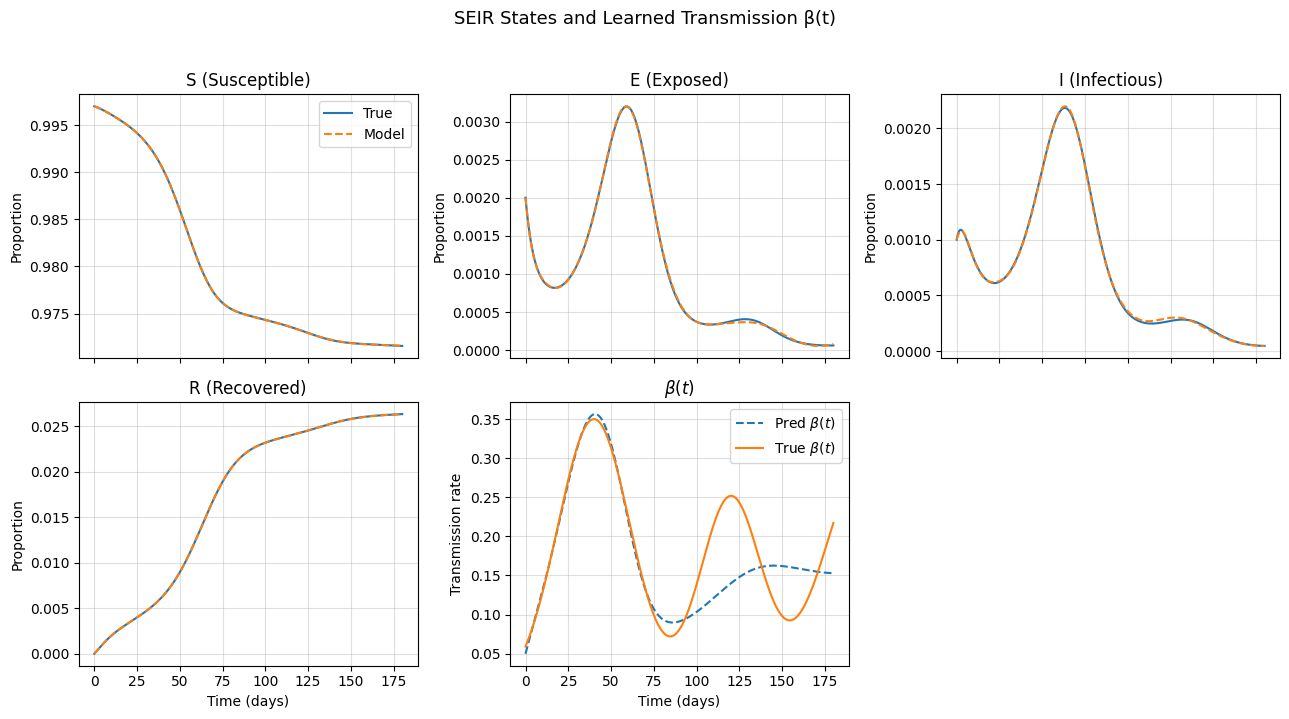

Saved figure: multi_run_results/states_and_beta_beta_learned.pdf


In [80]:
# --------------------------------------------
# (F) Plotting (S, E, I, R, and beta in one figure)
# --------------------------------------------
def plot_states_and_beta(params, t_data, data, scale_factor, run_id, beta_true=None):
    # Predict all 5 outputs: [S, E, I, R, beta_raw]
    pred_all = fwd(params, jnp.asarray(t_data).reshape(-1, 1))  # (T,5)
    pred_states = pred_all[:, :4]                                # (T,4)
    # beta_pred = jax.nn.softplus(pred_all[:, 4])                  # (T,)
    beta_pred = pred_all[:, 4]#jnp.clip(beta_pred, 0.0, 3.0)                    # match ODE cap (optional)

    # Convert to numpy for matplotlib
    t_np = np.asarray(t_data)
    pred_np = np.asarray(pred_states)
    beta_pred_np = np.asarray(beta_pred)

    # 2x3 grid: S, E, I, R, beta, (empty)
    fig, axs = plt.subplots(2, 3, figsize=(13, 7), sharex=True)
    axs = axs.flatten()
    names = ["S (Susceptible)", "E (Exposed)", "I (Infectious)", "R (Recovered)"]

    # Plot S, E, I, R
    for i in range(4):
        axs[i].plot(t_np, data[:, i] * scale_factor[i], label='True', linewidth=1.5)
        axs[i].plot(t_np, pred_np[:, i] * scale_factor[i], '--', label='Model', linewidth=1.5)
        axs[i].set_title(names[i])
        axs[i].set_ylabel("Proportion")
        axs[i].grid(True, alpha=0.4)
        if i == 0:
            axs[i].legend()

    # Plot beta(t)
    axb = axs[4]
    axb.plot(t_np, beta_pred_np, '--', label=r'Pred $\beta(t)$', linewidth=1.5)
    if beta_true is not None:
        axb.plot(t_np, np.asarray(beta_true), label=r'True $\beta(t)$', linewidth=1.5)
    axb.set_title(r"$\beta(t)$")
    axb.set_xlabel("Time (days)")
    axb.set_ylabel("Transmission rate")
    axb.grid(True, alpha=0.4)
    axb.legend()

    # Last panel empty (for clean layout)
    axs[5].axis('off')

    # Shared x-labels
    axs[3].set_xlabel("Time (days)")
    axs[4].set_xlabel("Time (days)")

    fig.suptitle("SEIR States and Learned Transmission β(t)", y=1.02, fontsize=13)
    fig.tight_layout()
    os.makedirs("multi_run_results", exist_ok=True)
    out = f"multi_run_results/states_and_beta_{run_id}.pdf"
    plt.savefig(out)
    plt.show()
    print(f"Saved figure: {out}")


plot_states_and_beta(trained, t_data, data, max_scl, run_id="beta_learned", beta_true=beta_true)


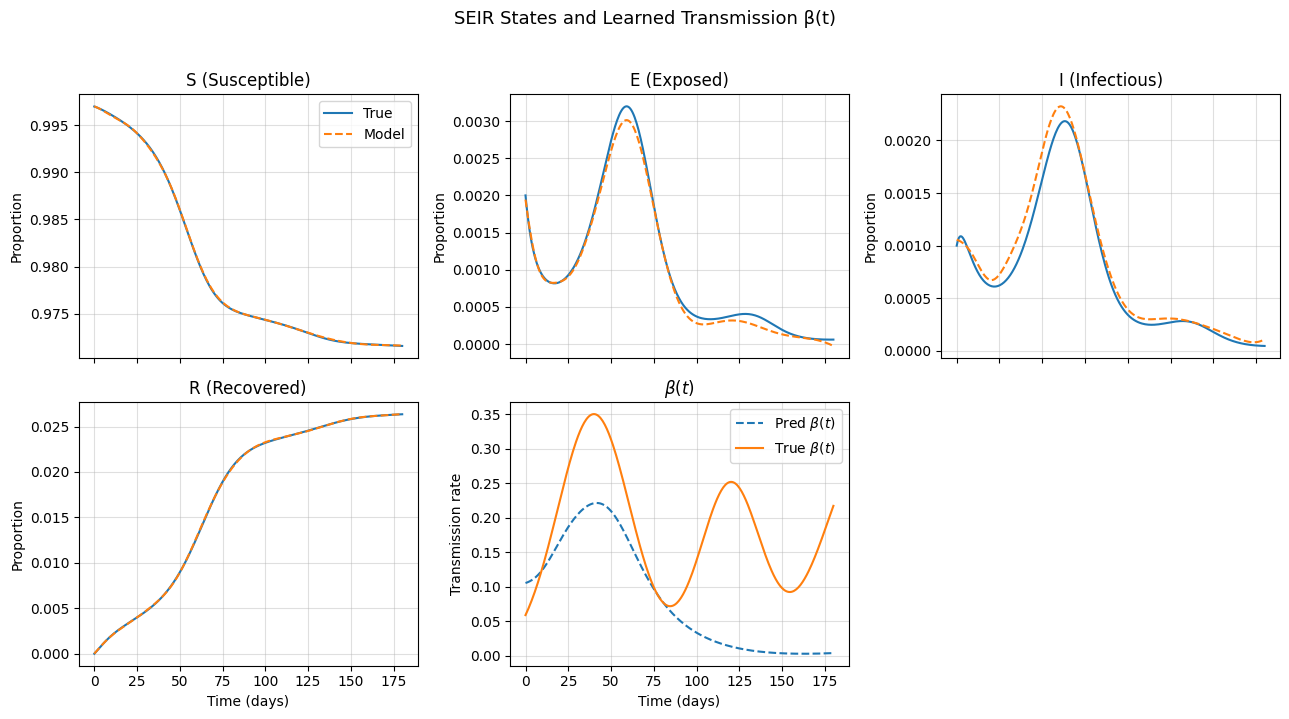

Saved figure: multi_run_results/states_and_beta_beta_learned.pdf


In [72]:
# --------------------------------------------
# (F) Plotting (S, E, I, R, and beta in one figure)
# --------------------------------------------
def plot_states_and_beta(params, t_data, data, scale_factor, run_id, beta_true=None):
    # Predict all 5 outputs: [S, E, I, R, beta_raw]
    pred_all = fwd(params, jnp.asarray(t_data).reshape(-1, 1))  # (T,5)
    pred_states = pred_all[:, :4]                                # (T,4)
    # beta_pred = jax.nn.softplus(pred_all[:, 4])                  # (T,)
    beta_pred = pred_all[:, 4]#jnp.clip(beta_pred, 0.0, 3.0)                    # match ODE cap (optional)

    # Convert to numpy for matplotlib
    t_np = np.asarray(t_data)
    pred_np = np.asarray(pred_states)
    beta_pred_np = np.asarray(beta_pred)

    # 2x3 grid: S, E, I, R, beta, (empty)
    fig, axs = plt.subplots(2, 3, figsize=(13, 7), sharex=True)
    axs = axs.flatten()
    names = ["S (Susceptible)", "E (Exposed)", "I (Infectious)", "R (Recovered)"]

    # Plot S, E, I, R
    for i in range(4):
        axs[i].plot(t_np, data[:, i] * scale_factor[i], label='True', linewidth=1.5)
        axs[i].plot(t_np, pred_np[:, i] * scale_factor[i], '--', label='Model', linewidth=1.5)
        axs[i].set_title(names[i])
        axs[i].set_ylabel("Proportion")
        axs[i].grid(True, alpha=0.4)
        if i == 0:
            axs[i].legend()

    # Plot beta(t)
    axb = axs[4]
    axb.plot(t_np, beta_pred_np, '--', label=r'Pred $\beta(t)$', linewidth=1.5)
    if beta_true is not None:
        axb.plot(t_np, np.asarray(beta_true), label=r'True $\beta(t)$', linewidth=1.5)
    axb.set_title(r"$\beta(t)$")
    axb.set_xlabel("Time (days)")
    axb.set_ylabel("Transmission rate")
    axb.grid(True, alpha=0.4)
    axb.legend()

    # Last panel empty (for clean layout)
    axs[5].axis('off')

    # Shared x-labels
    axs[3].set_xlabel("Time (days)")
    axs[4].set_xlabel("Time (days)")

    fig.suptitle("SEIR States and Learned Transmission β(t)", y=1.02, fontsize=13)
    fig.tight_layout()
    os.makedirs("multi_run_results", exist_ok=True)
    out = f"multi_run_results/states_and_beta_{run_id}.pdf"
    plt.savefig(out)
    plt.show()
    print(f"Saved figure: {out}")


plot_states_and_beta(trained, t_data, data, max_scl, run_id="beta_learned", beta_true=beta_true)


In [73]:
# --------------------------------------------
# (G) Two-step training with KAN (output dim = 5)
# --------------------------------------------
layers = [1, 30, 30, 30, 30, 5]      # 5 outputs: S,E,I,R,beta_raw
print("\n=== Training with learned beta(t) (two-step) ===")
key = jax.random.PRNGKey(706)
params = init_params_kan(layers, degree=3, key=key)
lambdas = [1.0] * 4                   # keep as before

# ----- Step 1: data-only warmup (10k epochs) -----
# loss weights order assumed: [IC, DATA, RES_S, RES_E, RES_I, RES_R]
loss_weight_step1 = [0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
epochs_step1 = 10_000

trained_step1 = train_model(
    params, lambdas,
    jnp.asarray(t_i), jnp.asarray(t_dense), jnp.asarray(t_dense),
    jnp.asarray(IC), jnp.asarray(data), jnp.asarray(max_scl),
    epochs=epochs_step1, loss_weight=loss_weight_step1
)

# (optional) save the warm-start params
flat1, _ = tree_flatten(trained_step1)
os.makedirs("multi_run_results", exist_ok=True)
np.savez("multi_run_results/params_run_beta_learned_step1_data_only.npz",
         *[np.array(p) for p in flat1])

# ----- Step 2: enable physics (IC + 4 ODE residuals) -----
# You can tweak these; this mirrors your original intent (IC, Data, then 4 residuals)
loss_weight_step2 = [0.1, 1.0, 1.0, 1.0, 1.0, 1.0]
# keep total ~150k as before -> 150001 - 10000 = 140001
epochs_step2 = 140_001

trained = train_model(
    trained_step1, lambdas,
    jnp.asarray(t_i), jnp.asarray(t_dense), jnp.asarray(t_dense),
    jnp.asarray(IC), jnp.asarray(data), jnp.asarray(max_scl),
    epochs=epochs_step2, loss_weight=loss_weight_step2
)

# Save final params
flat, _ = tree_flatten(trained)
np.savez("multi_run_results/params_run_beta_learned.npz",
         *[np.array(p) for p in flat])

# Plots
plot_predicted_vs_data(trained, t_data, data, max_scl, run_id="beta_learned")

print("✅ Done. Figures: pred_vs_true_runbeta_learned.pdf and beta_true_vs_pred_runbeta_learned.pdf")



=== Training with learned beta(t) (two-step) ===
Epoch 0, Loss: 5.19e+00
Epoch 1000, Loss: 1.12e-05
Epoch 2000, Loss: 2.71e-06
Epoch 3000, Loss: 1.86e-06
Epoch 4000, Loss: 1.34e-06
Epoch 5000, Loss: 9.61e-07
Epoch 6000, Loss: 6.76e-07
Epoch 7000, Loss: 8.95e-07
Epoch 8000, Loss: 4.14e-07
Epoch 9000, Loss: 3.27e-07
Epoch 0, Loss: 6.90e-07
Epoch 1000, Loss: 4.91e-07
Epoch 2000, Loss: 4.44e-07
Epoch 3000, Loss: 5.18e-07
Epoch 4000, Loss: 1.65e-07
Epoch 5000, Loss: 1.45e-06
Epoch 6000, Loss: 1.22e-07
Epoch 7000, Loss: 6.05e-07
Epoch 8000, Loss: 5.45e-07
Epoch 9000, Loss: 8.39e-08
Epoch 10000, Loss: 7.65e-08
Epoch 11000, Loss: 7.57e-08
Epoch 12000, Loss: 8.86e-08
Epoch 13000, Loss: 1.52e-07
Epoch 14000, Loss: 5.48e-08
Epoch 15000, Loss: 7.30e-08
Epoch 16000, Loss: 6.28e-08
Epoch 17000, Loss: 4.33e-08
Epoch 18000, Loss: 6.66e-07
Epoch 19000, Loss: 4.11e-08
Epoch 20000, Loss: 3.55e-08
Epoch 21000, Loss: 4.07e-08
Epoch 22000, Loss: 3.77e-08
Epoch 23000, Loss: 5.09e-08
Epoch 24000, Loss: 3.57e

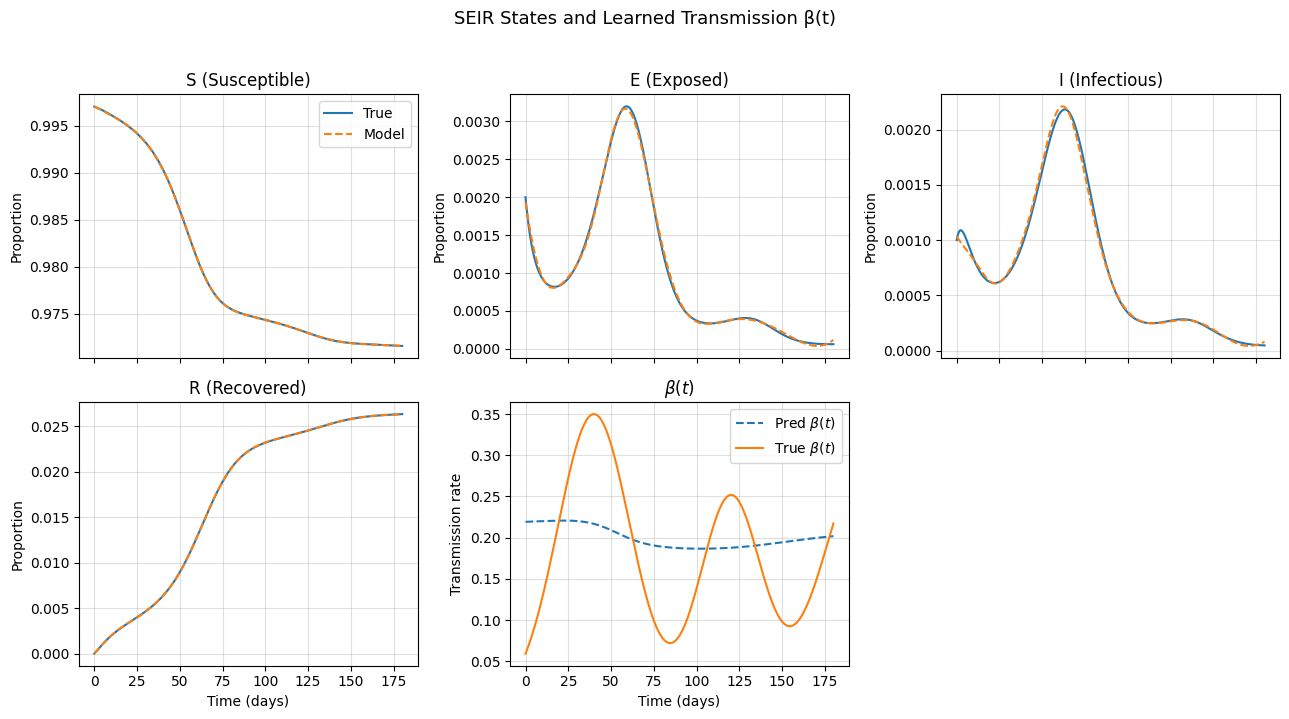

Saved figure: multi_run_results/states_and_beta_beta_learned.pdf


In [74]:
# --------------------------------------------
# (F) Plotting (S, E, I, R, and beta in one figure)
# --------------------------------------------
def plot_states_and_beta(params, t_data, data, scale_factor, run_id, beta_true=None):
    # Predict all 5 outputs: [S, E, I, R, beta_raw]
    pred_all = fwd(params, jnp.asarray(t_data).reshape(-1, 1))  # (T,5)
    pred_states = pred_all[:, :4]                                # (T,4)
    # beta_pred = jax.nn.softplus(pred_all[:, 4])                  # (T,)
    beta_pred = pred_all[:, 4]#jnp.clip(beta_pred, 0.0, 3.0)                    # match ODE cap (optional)

    # Convert to numpy for matplotlib
    t_np = np.asarray(t_data)
    pred_np = np.asarray(pred_states)
    beta_pred_np = np.asarray(beta_pred)

    # 2x3 grid: S, E, I, R, beta, (empty)
    fig, axs = plt.subplots(2, 3, figsize=(13, 7), sharex=True)
    axs = axs.flatten()
    names = ["S (Susceptible)", "E (Exposed)", "I (Infectious)", "R (Recovered)"]

    # Plot S, E, I, R
    for i in range(4):
        axs[i].plot(t_np, data[:, i] * scale_factor[i], label='True', linewidth=1.5)
        axs[i].plot(t_np, pred_np[:, i] * scale_factor[i], '--', label='Model', linewidth=1.5)
        axs[i].set_title(names[i])
        axs[i].set_ylabel("Proportion")
        axs[i].grid(True, alpha=0.4)
        if i == 0:
            axs[i].legend()

    # Plot beta(t)
    axb = axs[4]
    axb.plot(t_np, beta_pred_np, '--', label=r'Pred $\beta(t)$', linewidth=1.5)
    if beta_true is not None:
        axb.plot(t_np, np.asarray(beta_true), label=r'True $\beta(t)$', linewidth=1.5)
    axb.set_title(r"$\beta(t)$")
    axb.set_xlabel("Time (days)")
    axb.set_ylabel("Transmission rate")
    axb.grid(True, alpha=0.4)
    axb.legend()

    # Last panel empty (for clean layout)
    axs[5].axis('off')

    # Shared x-labels
    axs[3].set_xlabel("Time (days)")
    axs[4].set_xlabel("Time (days)")

    fig.suptitle("SEIR States and Learned Transmission β(t)", y=1.02, fontsize=13)
    fig.tight_layout()
    os.makedirs("multi_run_results", exist_ok=True)
    out = f"multi_run_results/states_and_beta_{run_id}.pdf"
    plt.savefig(out)
    plt.show()
    print(f"Saved figure: {out}")


plot_states_and_beta(trained, t_data, data, max_scl, run_id="beta_learned", beta_true=beta_true)
